In [1]:
# Random Forest
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
start = time.time()
#getting data
data = pd.read_csv('stars_train.csv')

data.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3484,0.000551,0.0998,16.67,Red,M,0
1,23000,127000.000000,36.0000,-5.76,Blue,O,4
2,4287,630000.000000,1315.0000,-9.20,Orange,K,5
3,3462,0.005300,0.1480,11.47,Red,M,1
4,36108,198000.000000,10.2000,-4.40,Blue,O,3


Color
Red                   62
Blue                  33
Blue White            26
yellow-white           9
White                  8
Orange                 2
Yellowish              2
Orange-Red             1
Pale yellow orange     1
dtype: int64 

Spectral_Class
M    62
B    28
O    26
F    13
A    10
K     4
G     1
dtype: int64 



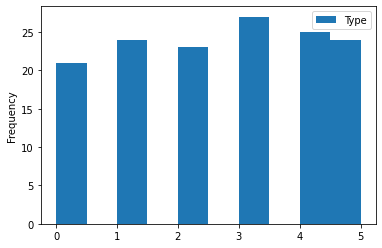

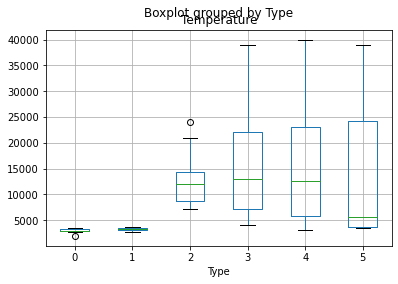

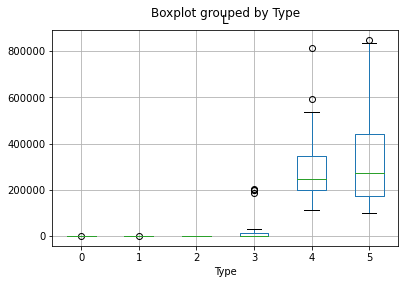

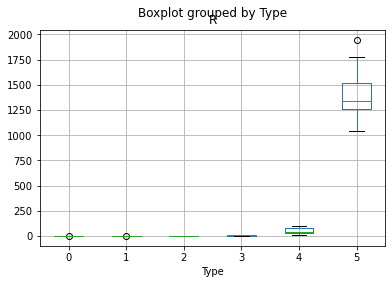

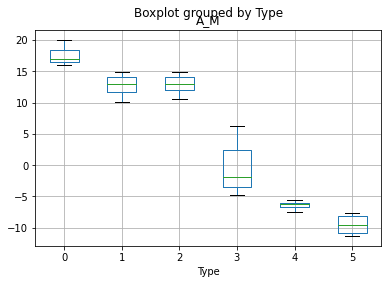

In [2]:
#looking through relationships between features and the label

num_features = ['Temperature','L', 'R', 'A_M']
cat_features = ['Color', 'Spectral_Class']
features = num_features + cat_features
label = 'Type'

data.plot.hist(y=label) #labels seem to be pretty evenly distributed

for feature in num_features: #all numeric features seem to have some relationship with label
    data.boxplot(column=feature, by=label)

for feature in cat_features: #both features are unevenly distributed
    tempf = data.value_counts(feature)
    print(tempf, '\n')


In [3]:
#Random Forest seems to be a good option
#creating model using pipeline

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.utils import class_weight #resolves any data imbalances

#splitting data
train, test = train_test_split(data, test_size=0.60,stratify=data[label],random_state=4)


#scaling step
numeric_features = [0,1,2,3]
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])

#encoding step
categorical_features = [4,5]
cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

#combining steps into one transformer for preprocessing
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, numeric_features),('cat', cat_transformer, categorical_features)])




#finding best hyperparameters
n_estimators = [int(n) for n in np.linspace(10, 300, 20)]
max_depth = [int(d) for d in np.linspace(5, 20, 10)]
max_features = ['auto', 'sqrt']
random_state = [int(r) for r in np.linspace(1, 100, 20)]

hyper_dict = {
    'n_estimators': n_estimators, 
    'max_depth':max_depth, 
    'max_features':max_features,
    'random_state':random_state
}

random_model = RandomizedSearchCV(
    estimator=RandomForestClassifier(),param_distributions=hyper_dict,
    n_iter = 100,cv = 3,verbose=2,random_state=42,n_jobs = -1
)
#encoding data
enc_train = pd.get_dummies(train, columns=['Color'], drop_first=False)
enc_train = pd.get_dummies(enc_train, columns=['Spectral_Class'], drop_first=False)
#scaling data
enc_features = [col for col in enc_train.columns if col != label]
scaled_enc_features = StandardScaler().fit_transform(enc_train[enc_features])
#getting best parameters
random_fitted_model = random_model.fit(scaled_enc_features, enc_train[label])
print(random_fitted_model.best_params_)




#creating the classifier with best params and combining with preprocessor
classifier = RandomForestClassifier(random_state=37,n_estimators=177, max_features='sqrt', max_depth=10, class_weight='balanced')
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])
model = pipeline.fit(train[features], train[label])


predictions = model.predict(test[features])


print('Classification Report:\n',classification_report(test[label], predictions))
print('Confusion Matrix:\n',confusion_matrix(test[label], predictions))

probabilities = model.predict_proba(test[features])

print('\nAUC Score (ovr):',roc_auc_score(test[label],probabilities, multi_class='ovr'))
print('\nAUC Score (ovo):',roc_auc_score(test[label],probabilities, multi_class='ovo'))

#model is showing perfect metric scores

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'random_state': 37, 'n_estimators': 177, 'max_features': 'sqrt', 'max_depth': 10}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        16
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        14

    accuracy                           1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87

Confusion Matrix:
 [[13  0  0  0  0  0]
 [ 0 15  0  0  0  0]
 [ 0  0 14  0  0  0]
 [ 0  0  0 16  0  0]
 [ 0  0  0  0 15  0]
 [ 0  0  0  0  0 14]]

AUC Score (ovr): 1.0

AUC Score (ovo): 1.0


In [4]:
#creating final predictions

final_test_data = pd.read_csv('stars_competitor_test.csv')
final_predictions = pd.DataFrame()
final_predictions['ID'] = [i for i in range(len(final_test_data))]
final_predictions['predicted'] = model.predict(final_test_data[features])
final_predictions_csv = final_predictions.to_csv('[Mazumder]_[Arnav]_Fall21.csv', index=False)
end = time.time()
print(end - start)

20.27989625930786
